In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt 

# Gesture recognition 

Second attempt at gesture recognition without markers.  
Following: https://core.ac.uk/download/pdf/295558123.pdf

This approach is based of skin-color filtering against background, then making a boundary, then computing convex properties in order to categorize between different gestures. 


## The data 

This is the type of images we use, and expect to see. Namely, we have images with only the hand/ arm against a single color, flat background. 

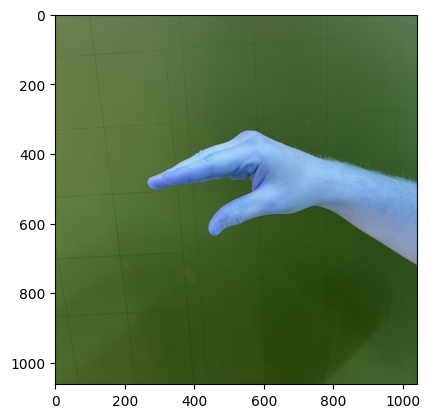

In [3]:
I = cv.imread("./data/raw/img/open1.png")



plt.imshow(I)

We use the color space YBR as this makes the image luma-independent, making the result robust agains lumination of the image

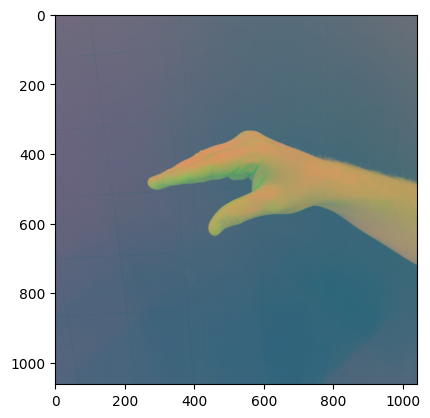

In [4]:
imgYCC = cv.cvtColor(I, cv.COLOR_BGR2YCR_CB)

plt.imshow(imgYCC)

Each pixel is subjected to conditions, classifying it into either skin color or not. 

(1062, 1040)


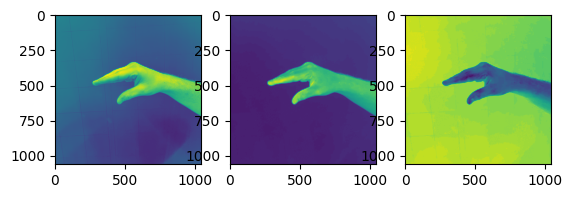

In [5]:

Y = imgYCC[:, :, 0]

CR = imgYCC[:, :, 1]

CB = imgYCC[:, :, 2]

fig = plt.figure()
s1 = fig.add_subplot(1, 3, 1)
s2 = fig.add_subplot(1, 3, 2)
s3 = fig.add_subplot(1, 3, 3)

s1.imshow(Y)
s2.imshow(CR)
s3.imshow(CB)

print(Y.shape)



In [6]:

Y_mask = (Y>80)

CB_mask = (85<CB)&(CB<135)

CR_mask = (135<CR)&(CR<180)


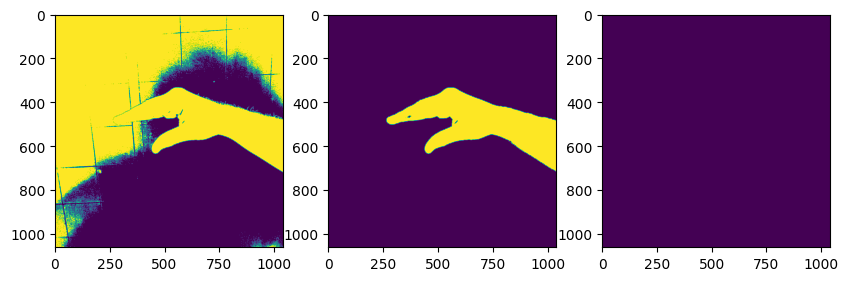

In [7]:
fig = plt.figure(figsize=(10,4))
s1 = fig.add_subplot(1, 3, 1)
s2 = fig.add_subplot(1, 3, 2)
s3 = fig.add_subplot(1, 3, 3)

s1.imshow(Y_mask)
s2.imshow(CR_mask)
s3.imshow(CB_mask)

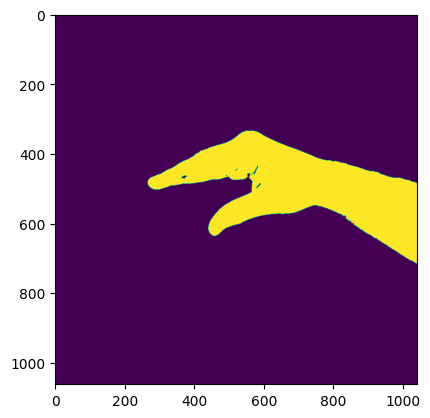

In [14]:
mask = Y_mask&CR_mask&CB_mask

plt.imshow(mask)


In [9]:
def derivative_of_gaussian(I, sigma):
    """
    Estimates the horizontal and vertical image derivatives
    by convolving with the derivatives of a 2D Gaussian.
    Returns the derivative images (Ix, Iy) and the gradient
    magnitude Im.
    """
    h = int(np.ceil(3*sigma))
    x = np.arange(2*h + 1) - h
    e = np.exp(-x**2/(2*sigma**2))
    g = e/np.sqrt(2*np.pi*sigma**2)
    d = -x*e/(sigma*sigma*sigma*np.sqrt(2*np.pi))
    Ix = np.zeros_like(I)
    Iy = np.zeros_like(I)
    for row in range(I.shape[0]): Ix[row,:] = np.convolve(I[row,:], d, mode='same')
    for col in range(I.shape[1]): Ix[:,col] = np.convolve(Ix[:,col], g, mode='same')
    for col in range(I.shape[1]): Iy[:,col] = np.convolve(I[:,col], d, mode='same')
    for row in range(I.shape[0]): Iy[row,:] = np.convolve(Iy[row,:], g, mode='same')
    return Ix, Iy, np.sqrt(Ix**2 + Iy**2)


def extract_local_maxima(H, threshold, max_number=True):
    """
    Returns the row and column of cells whose value is strictly greater than its
    8 immediate neighbors, and greater than or equal to a threshold. The threshold
    is specified as a fraction of the maximum array value.

    Note: This returns (row,column) coordinates.
    """
    assert(len(H.shape) == 2) # Must be gray-scale array
    assert(threshold >= 0 and threshold <= 1) # Threshold is specified as fraction of maximum array value
    absolute_threshold = threshold*H.max()
    maxima = []
    for row in range(1, H.shape[0]-1):
        if len(maxima) > 100 and max_number: 
            break

        for col in range(1, H.shape[1]-1):
            window = H[row-1:row+2, col-1:col+2]
            center = window[1,1]
            window[1,1] = 0.0
            if center > window.max() and center >= absolute_threshold:
                maxima.append((row,col))
            window[1,1] = center
    maxima = np.array(maxima)
    print(maxima.shape)
    return maxima[:,0], maxima[:,1]


def compute_skin_mask(I): 
    imgYCC = cv.cvtColor(I, cv.COLOR_BGR2YCR_CB)


    Y = imgYCC[:, :, 0]

    CR = imgYCC[:, :, 1]

    CB = imgYCC[:, :, 2]


    Y_mask = (Y>80)

    CB_mask = (85<CB)&(CB<135)

    CR_mask = (135<CR)&(CR<180)

    return Y_mask&CR_mask&CB_mask





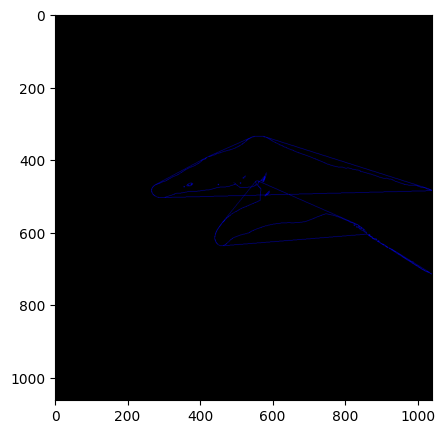

In [27]:

mask = (mask*255).astype(np.uint8)
edges = cv.Canny(mask, 0, 255)
contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
hulls = []

for contour in contours: 
    hull = cv.convexHull(contour)
    hulls.append(hull)

drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (0, 0, 255)
    cv.drawContours(drawing, contours, i, color)
    cv.drawContours(drawing, hulls, i, color)

plt.figure(figsize=(13,5))
plt.imshow(drawing)
plt.show()

# Testing in video 

In [26]:
import cv2 as cv
import numpy as np 
from src.utils.imageProcessing import *

frameWidth = 450
frameHeight = 640
cap = cv.VideoCapture(1)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10,150)

counters = []


while True:

    success, img = cap.read()

    img = compute_skin_mask(img)
    img = (img*255).astype(np.uint8)


    edges = cv.Canny(img, 100, 200)

        
    cv.imshow("result", edges)
    
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

2024-03-05 15:31:18.464 Python[4104:160453] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-03-05 15:31:20.412 Python[4104:160453] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


KeyboardInterrupt: 